# Quantum Chemistry: Variational Quantum Eigensolver
## Simulate the dissociation curve (energy vs. bond length) for a $H_2$ molecule
Based on http://openqemist.1qbit.com/docs/vqe_microsoft_qsharp.html#the-variational-quantum-eigensolver-vqe

In [1]:
%%timeit -n 1 -r 1
import qsharp

3.63 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [2]:
%%timeit -n 1 -r 1
from qsharp.chemistry import load_broombridge, load_fermion_hamiltonian, load_input_state, encode

Adding package microsoft.quantum.chemistry.jupyter.

1.89 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## 1. Load computed $H_2$  from file
To generate:

1. Go to: https://arrows.emsl.pnnl.gov/api/qsharp_chem

2. Enter `HH theory{qsharp_chem}`

3. Under Datafiles, click "download"

In [3]:
import qsharp
from qsharp.chemistry import load_broombridge, load_fermion_hamiltonian, load_input_state, encode

filename = 'data/hydrogen_0.2.yaml'
broombridge_data =  load_broombridge(filename)
problem_description = broombridge_data.problem_description[0]
ferm_hamiltonian = problem_description.load_fermion_hamiltonian()
input_state = load_input_state(filename, "UCCSD |G>")
num_qubits, hamiltonian_term_list, input_state_terms, energy_offset = encode(ferm_hamiltonian, input_state)

### Hamiltonian terms
## $H = \sum_{pq}{h_{pq}} a_p^{\dagger}a_q^{\dagger} + \frac{1}{2} \sum_{pqrs}{h_{pqrs}} a_p^{\dagger}a_q^{\dagger}a_{r}a_{s}$

In [4]:
import pprint as pp
pp.pprint(hamiltonian_term_list)

([([0], [0.17120128499999998]),
  ([1], [0.17120128499999998]),
  ([2], [-0.222796536]),
  ([3], [-0.222796536])],
 [([0, 1], [0.1686232915]),
  ([0, 2], [0.12054614575]),
  ([0, 3], [0.16586802525]),
  ([1, 2], [0.16586802525]),
  ([1, 3], [0.12054614575]),
  ([2, 3], [0.1743495025])],
 [],
 [([0, 1, 2, 3], [0.0, -0.0453218795, 0.0, 0.0453218795])])


### Input trial state terms
## $T(\vec{\theta}) = \sum_{ij} \theta_{ij} a_{i}^{\dagger} a_{j} + \theta_{ijkl} a_{i}^{\dagger} a_{j}^{\dagger} a_{k} a_{l}$

In [5]:
pp.pprint(input_state_terms)

(3,
 [((0.001, 0.0), [2, 0]),
  ((-0.001, 0.0), [3, 1]),
  ((0.001, 0.0), [2, 3, 1, 0]),
  ((1.0, 0.0), [0, 1])])


In [6]:
def get_var_params(input_state_terms):
    """Get variational parameters from the input state"""
    _, var_params = input_state_terms
    return [param for ((param, _), _) in var_params[:-1]]

def new_input_state(var_params, input_state_terms):
    """Returns a new input state with updated variational parameters"""
    val, terms = input_state_terms
    new_amps = [((param, val), indices) for (((_, val), indices), param) in zip(terms, list(var_params) + [1.0])]
    return (val, new_amps)

var_params = get_var_params(input_state_terms)
var_params

[0.001, -0.001, 0.001]

## 2. Import Q# library operation
To be able to access the namespace, we need to add it to the qsharp packages list and reload.

We can then import the wrapper for the `EstimateEnergy` operation directly into our Python namespace using `QSharpCallable`.

In [7]:
qsharp.packages.add("Microsoft.Quantum.Chemistry")
qsharp.reload()
estimate_energy = qsharp.QSharpCallable("Microsoft.Quantum.Chemistry.JordanWigner.VQE.EstimateEnergy", "")

Adding package Microsoft.Quantum.Chemistry.

Reloading workspace.

### Resource estimation

Estimate quantum resources required to run this algorithm.

In [8]:
estimate_energy.estimate_resources(jwHamiltonian=(num_qubits, hamiltonian_term_list, input_state_terms, energy_offset), nSamples=1)

{'CNOT': 896,
 'QubitClifford': 1148,
 'R': 168,
 'Measure': 70,
 'T': 0,
 'Depth': 0,
 'Width': 4,
 'BorrowedWidth': 0}

## 3. Quantum evaluation
Here we create a function that evaluates the Hamiltonian on a given number of qubits using the VQE algorithm and returns the energy result.

In [9]:
def evaluate_H(var_params, num_qubits, hamiltonian_term_list, input_state_terms, energy_offset, n_samples, verbose=False):
    """Runs EstimateEnergy with the input state modified by new variational parameters"""
    input_state_terms = new_input_state(var_params, input_state_terms)
    energy = estimate_energy.simulate(jwHamiltonian=(num_qubits, hamiltonian_term_list, input_state_terms, energy_offset), nSamples=1e18)
    print(f"Parameters: {var_params}, calculated energy: {energy}") if verbose else _
    return energy

In [10]:
evaluate_H(var_params, num_qubits, hamiltonian_term_list, input_state_terms, energy_offset, n_samples=1e18, verbose=True)

Parameters: [0.001, -0.001, 0.001], calculated energy: -1.1163206832928165


-1.1163206832928165

### Minimize the energy
The goal of VQE is to estimate the ground state energy of a given Hamiltonian variationally. Here, we run the VQE circuit multiple times to get the expectation value of the energy with varying input parameters, until the global minimum is found.

In [11]:
from scipy.optimize import minimize

def VQE(initial_var_params, num_qubits, hamiltonian_term_list, input_state_terms, energy_offset, n_samples, verbose):
    opt_result = minimize(evaluate_H,
                          initial_var_params,
                          args=(num_qubits, hamiltonian_term_list, input_state_terms, energy_offset, n_samples, verbose),
                          method="COBYLA",
                          tol=0.000001,
                          options={'disp': True, 'maxiter': 200,'rhobeg' : 0.05})
    return opt_result

In [12]:
opt_result = VQE(var_params, num_qubits, hamiltonian_term_list, input_state_terms, energy_offset, n_samples=1e18, verbose=True)
print(opt_result)

Parameters: [ 0.001 -0.001  0.001], calculated energy: -1.1163206834000161
Parameters: [ 0.051 -0.001  0.001], calculated energy: -1.1143693480147085
Parameters: [0.001 0.049 0.001], calculated energy: -1.1144494156823095
Parameters: [ 0.001 -0.001  0.051], calculated energy: -1.0941301538175583
Parameters: [-0.0033645  -0.00518542 -0.04863299], calculated energy: -1.1305266765693185
Parameters: [-0.01021579 -0.01175558 -0.09772365], calculated energy: -1.1366498431269147
Parameters: [-0.04496727 -0.04625581 -0.10782658], calculated energy: -1.133169622130144
Parameters: [ 0.00741028 -0.02948449 -0.09781082], calculated energy: -1.1362581504555616
Parameters: [ 0.00679366  0.01160861 -0.13852552], calculated energy: -1.1360580830871494
Parameters: [-1.71106807e-03 -7.34886915e-05 -1.18124585e-01], calculated energy: -1.1372266413690135
Parameters: [ 0.01101093  0.02025182 -0.11105121], calculated energy: -1.1367639233856788
Parameters: [-0.01406918  0.00127264 -0.13981479], calculated 

In [13]:
# Print difference with exact FCI value known for this bond length
fci_value = -1.1372704220924401
print("Difference with exact FCI value: ", abs(opt_result.fun - fci_value))

Difference with exact FCI value:  8.376432880652374e-09


In [14]:
def compute_energy_vqe(problem_description, verbose=False):
    """Parse the problem description and variationally find the ground state energy in Ha using VQE"""
    ferm_hamiltonian = problem_description.load_fermion_hamiltonian()
    input_state = load_input_state(filename, "UCCSD |G>")
    num_qubits, hamiltonian_term_list, input_state_terms, energy_offset = encode(ferm_hamiltonian, input_state)
    var_params = get_var_params(input_state_terms)
    opt_result = VQE(var_params, num_qubits, hamiltonian_term_list, input_state_terms, energy_offset, n_samples=1e18, verbose=verbose)

    if opt_result.status == 1:
        return opt_result.fun

In [15]:
problem_description = broombridge_data.problem_description[0]
compute_energy_vqe(problem_description)

-1.1372704137575473

## 3. Calculate one and two-electron integrals using PySCF for a given bond length

First, create a function that returns a molecule with a varying bond length.

In [16]:
import numpy as np
from pyscf import gto, scf, fci, ao2mo

def create_H2_molecule(bond_length):
    # Create molecule object with PySCF
    H2 = [['H',[ 0, 0, 0]], ['H',[0,0, bond_length]]]
    mol = gto.Mole()
    mol.atom = H2
    mol.basis = "sto-3g"
    mol.charge = 0
    mol.spin = 0
    mol.build()
    return mol

Here are some functions that wrangle the output from PySCF into Broombridge format that is compatible with the Q# operation `EstimateEnergy`.

In [17]:
from pyscf import gto, scf, fci, ao2mo

def compute_integrals(problem_description, molecule, RHF):
    """
    Compute one and two-electron integrals and output in Broombridge format
    """
    one_electron_integrals = problem_description.hamiltonian['OneElectronIntegrals']['Values']
    two_electron_integrals = problem_description.hamiltonian['TwoElectronIntegrals']['Values']
    
    # Get molecular orbital coefficients
    h_pq = np.around(RHF.mo_coeff.T @ RHF.get_hcore() @ RHF.mo_coeff, decimals=6)
    one_electron_integrals = [([j, i], h_pq[i-1, j-1]) for (j, i), _ in one_electron_integrals]

    # Get interaction terms
    h_pqrs = np.around(ao2mo.restore(1, ao2mo.kernel(molecule, RHF.mo_coeff), 2), 6)
    two_electron_integrals = [([l, k, j, i], h_pqrs[i-1, j-1, k-1, l-1]) for (l, k, j, i), _ in two_electron_integrals]

    return one_electron_integrals, two_electron_integrals

def updated_problem_description(filename, one_electron_integrals, two_electron_integrals, nuclear_repulsion):
    """Update problem description with new one and two-electrom integral and nuclear repulsion terms"""
    broombridge_data = load_broombridge(filename)
    problem_description = broombridge_data.problem_description[0]
    problem_description.hamiltonian['OneElectronIntegrals']['Values'] = one_electron_integrals
    problem_description.hamiltonian['TwoElectronIntegrals']['Values'] = two_electron_integrals
    problem_description.coulomb_repulsion['Value'] = nuclear_repulsion

    return problem_description

Run the PySCF Restricted Hartree-Fock simulation

In [18]:
molecule = create_H2_molecule(bond_length=1.624/1.88973)
RHF = scf.RHF(molecule)
RHF.scf()
energy_nuc = RHF.energy_nuc()
one_el, two_el = compute_integrals(problem_description, molecule, RHF)
one_el, two_el, energy_nuc

converged SCF energy = -1.10067441313401


([([1, 1], -1.184281), ([2, 2], -0.538244)],
 [([1, 1, 1, 1], 0.652123),
  ([1, 2, 2, 1], 0.188121),
  ([1, 1, 2, 2], 0.643609),
  ([2, 2, 2, 2], 0.676401)],
 0.6157648096008939)

Use this as input to the VQE algorithm and evaluate quantumly

In [19]:
new_pd = updated_problem_description(filename, one_el, two_el, energy_nuc)
compute_energy_vqe(new_pd)

-1.1270309926775335

## 4. Run VQE for varying bond length

Now, we will take everything we've done and run it in a for-loop to calculate the energy for a list of bond lengths. 

In [20]:
energy = []
bond_lengths = np.arange(0.4,1.7,0.1)

for bond_length in bond_lengths:
    molecule = create_H2_molecule(bond_length=bond_length)
    RHF = scf.RHF(molecule)
    RHF.scf()
    energy_nuc = RHF.energy_nuc()
    one_el, two_el = compute_integrals(problem_description, molecule, RHF)
    new_pd = updated_problem_description(filename, one_el, two_el, energy_nuc)
    _energy = compute_energy_vqe(new_pd)
    energy.append(_energy)

converged SCF energy = -0.904361394163539
converged SCF energy = -1.04299627454009
converged SCF energy = -1.1011282422677
converged SCF energy = -1.11734903499028
converged SCF energy = -1.11085039747659
converged SCF energy = -1.09191404102006
converged SCF energy = -1.06610864931794
converged SCF energy = -1.03653887502918
converged SCF energy = -1.00510670656849
converged SCF energy = -0.973110615777578
converged SCF energy = -0.941480654707798
converged SCF energy = -0.910873554594386
converged SCF energy = -0.881732449946057


Text(0, 0.5, 'Energy (Ha)')

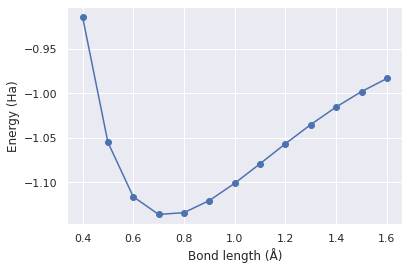

In [21]:
import matplotlib as mpl
import seaborn as sns
import pylab as pl
%matplotlib inline
sns.set_theme(style="darkgrid")

pl.plot(bond_lengths, energy, "o-")
pl.xlabel("Bond length (Å)")
pl.ylabel("Energy (Ha)")